In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

import gammapy
import numpy as np
import astropy
import regions
import scipy

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("scipy", scipy.__version__)


from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle

from regions import CircleSkyRegion

from gammapy.data import DataStore, GTI, Observation, EventList
from gammapy.datasets import (FluxPointsDataset, MapDataset, MapDatasetEventSampler, 
                              Datasets, SpectrumDataset, SpectrumDatasetOnOff)
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SafeMaskMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    TemplateSpectralModel,
    FoVBackgroundModel,
)


import copy
import scipy.stats as stats

from gammapy.estimators import (
    FluxPoints, 
    FluxPointsEstimator, 
    TSMapEstimator
)

from regions import CircleSkyRegion

gammapy: 1.3
numpy: 2.1.3
astropy 6.1.6
regions 0.10
scipy 1.14.1


In [2]:
import warnings
from gammapy.utils.deprecation import GammapyDeprecationWarning
# 1. Hide the Gammapy “FixedPointingInfo will be required” notice
warnings.filterwarnings("ignore", category=GammapyDeprecationWarning)

In [3]:
BASE_PATH=Path(".")

In [4]:
def save_figure(filename):       #routine for saving figures
    path = BASE_PATH / filename      #saving paths
    path.parent.mkdir(parents=True, exist_ok=True)  #create a directory
    plt.savefig(path, dpi=300, bbox_inches='tight')     #dpi is the resolution
    plt.clf()                #clear
    plt.close()

In [5]:
import os
Nsim = 100              #definition of simulation number

## Creation of needed directories

Nsims=f"./{Nsim}sims"
try:
    # Create target Directory
    os.mkdir(Nsims)
except FileExistsError:
    print("Directory " , Nsims ,  " already exists")
    
events=f"./{Nsim}sims/events"
try:
    os.mkdir(events)
except FileExistsError:
    print("Directory " , events ,  " already exists")   
    
bestfit=f"./{Nsim}sims/best-fit"
try:
    os.mkdir(bestfit)
except FileExistsError:
    print("Directory " , bestfit ,  " already exists")  

spectra=f"./{Nsim}sims/spectra"
try:
    os.mkdir(spectra)
    print("Directory " , spectra ,  " Created ") 
except FileExistsError:
    print("Directory " , spectra ,  " already exists")

Directory  ./100sims/spectra  Created 


In [6]:
####
# MAP GEOMETRY
####

ENERGY_AXIS = MapAxis.from_energy_bounds(
    "0.1 TeV", "100.0 TeV", nbin=10, per_decade=True       #IRF range
)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds(
    "0.01 TeV", "350 TeV", nbin=20, per_decade=True, name="energy_true"    #larger range for E_true
)
MIGRA_AXIS = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)

center = SkyCoord.from_name("NGC 1068").icrs

offset = 0.5 * u.deg

pointing_position = center.directional_offset_by(
    position_angle=0 * u.deg, separation=offset
)

WCS_GEOM = WcsGeom.create(
    skydir=pointing_position,
    width=(10, 10),         #REMEMBER: if you want to point off-axis 4°, you need a wider field     
    binsz=0.02,          #binsize simulation << PSF 
    frame="icrs",
    axes=[ENERGY_AXIS],
)

In [7]:
MainSource = "NGC1068"        #here insert all the information that I want in the filename
MainSourceAn = "NGC1068_Fermi"               #name that I have to put in the analysis

In [8]:
filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
irfs = load_irf_dict_from_file(filename)

In [9]:
#########
# Empty dataset creation with infromation from IRF
########
empty = MapDataset.create(
    WCS_GEOM, 
    energy_axis_true=ENERGY_AXIS_TRUE, 
    migra_axis=MIGRA_AXIS,
    name="my-dataset",
)


#####
# IRF definition, exposure definition, observation definition--> see previous notebook
#####

LIVETIME = 50 * u.hr                          #observation time with units
ext = int(LIVETIME.value)                         # exposure time as integer"
obs_id="0001"                                     # obs_id could be everything


observation = Observation.create(
    obs_id=obs_id, pointing=pointing_position, livetime=LIVETIME, irfs=irfs 
) 


## which maps to make
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])    #with Edisp
#maker = MapDatasetMaker(selection=["exposure", "psf", "background"])          #without the Edisp


dataset = maker.run(empty, observation)

dataset.write(f"dataset_{MainSource}_{ext}hr.fits", overwrite=True)
print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 5411536.35
  Total excess counts             : -5411536.35

  Predicted counts                : 5411536.35
  Predicted background counts     : 5411536.35
  Predicted excess counts         : nan

  Exposure min                    : 2.81e+00 m2 s
  Exposure max                    : 3.00e+11 m2 s

  Number of total bins            : 7500000 
  Number of fit bins              : 7500000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [10]:
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.modeling.models import EBLAbsorptionNormSpectralModel
# Source
point_model = PointSpatialModel(
    lon_0="40.669 deg", 
    lat_0="-0.013 deg", 
    frame='icrs'
)

# Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
source_4fgl = catalog_4fgl["4FGL J0242.6-0000"]          # NGC 1068
fermi_model = source_4fgl.sky_model()

# Specify the redshift of the source
redshift = 0.00379

# Load the EBL model. Here we use the model from Dominguez, 2011
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

# The Fermi model is multiplied by the EBL to get the final model
spectral_model = fermi_model.spectral_model * ebl 


# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")



sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=point_model,
 #                   temporal_model=expdecay_model,
                    name=MainSourceAn,
                    )

# Define the whole model
models = Models([sky_model, bkg_model])


models[0].spatial_model.parameters['lon_0'].frozen=True       #Spatial coordinate freezed
models[0].spatial_model.parameters['lat_0'].frozen=True

print(models) 

#print(models.to_yaml())
# save it to disk
#file_model = "./M82_Nsim_ECPL.yaml"
#models.write(file_model, overwrite=True)

Models

Component 0: SkyModel

  Name                      : NGC1068_Fermi
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.350   +/-    0.05             
    amplitude                     :   6.49e-13   +/- 4.3e-14 1 / (MeV s cm2)
    reference             (frozen):   1048.521       MeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.004                   
    lon_0                 (frozen):     40.669       deg         
    lat_0                 (frozen):     -0.013       deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00          

In [11]:
from gammapy.data import observatory_locations

exp = [50]     

for j in exp:         #loop on exposure times
    ext = int(j)      # to facilitate the references in the loops
    dataset = MapDataset.read(f'dataset_{MainSource}_{ext}hr.fits', name="my-dataset") #read the one that we created
    dataset.models = models     
    dataset_original = models.copy()         #this will be useful for the final plot
    for i in np.arange(Nsim):                 # we simulate N times
        observation = Observation.create(
        obs_id=i, pointing=pointing_position, livetime=j*u.hr, irfs=irfs, tstart = 30 * u.min, reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc"),
        location = observatory_locations["cta_north"]
        )
        
        sampler = MapDatasetEventSampler(random_state=i)
        events = sampler.run(dataset, observation)

        observation.events = events
        observation.write(f"./{Nsim}sims/events/{MainSource}_{ext}hr_events_{i}.fits", include_irfs=False, overwrite=True)

The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta informa

In [15]:
import glob, os, itertools
input_filenames = []
input_filenames.append(glob.glob(os.path.join("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/100sims/events/", '*.fits')))
input_filenames = tuple(itertools.chain.from_iterable(input_filenames))

datastore = DataStore.from_events_files(np.sort(input_filenames), irfs_paths="/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits")
datastore.hdu_table.write("hdu-index.fits.gz", overwrite=True)
datastore.obs_table.write("obs-index.fits.gz", overwrite=True)

In [16]:
from gammapy.maps import MapAxis, RegionGeom
# let's load the previously created Observation index files:

observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

# we consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg;
# we define the ON region, assuming a circle of 0.2 deg of radius, for the source;
width = 2.0  #deg
binsz = 0.02 #deg
radius= 0.11  #deg

# let's define an exclusion region, in order to better estimate the bkg:
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
    #npix=(npix, npix), binsz=binsz, skydir=w1.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])

# Create the reconstruced energy range:
e_min, e_max = 0.1 * u.TeV, 100 * u.TeV

energy_axis = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=10, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 350, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to determine the reflected regions, excluding the source region:
maker_fov = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

# let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 1 deg.
safe_mask_maker = SafeMaskMaker(
        methods=["aeff-max"], aeff_percent=10, position=pointing_position
    )

# create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

# let's create the dataset for each observation and stack them all:
datasets = Datasets()

# let's loop over observations
for observation in observations:
    # generate a dataset object
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # fill the dataset with the events of the observation
    counts.fill_events(observation.events)

    # calculate the bkg
    dataset_on_off = maker_fov.run(dataset, observation)
    # set a safe range for the analysis
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

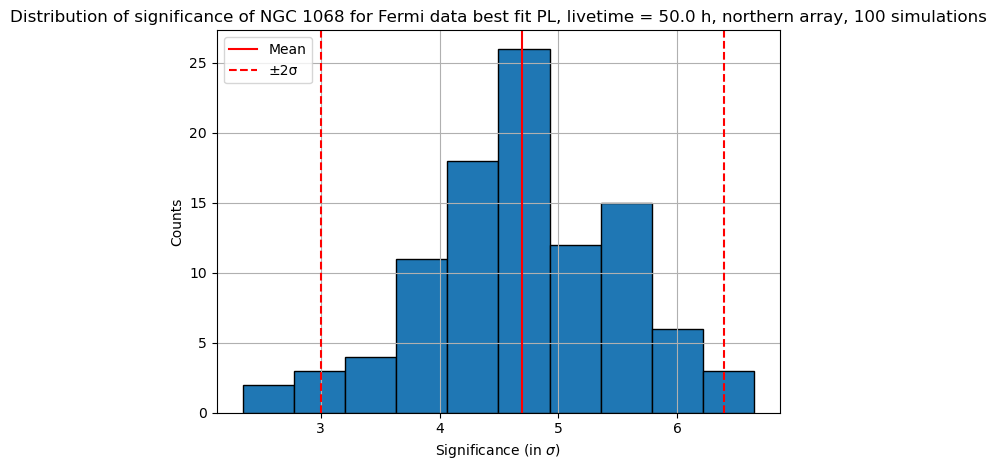

Significance : 4.69 +/- 0.85


In [18]:
from gammapy.stats import WStatCountsStatistic

# Define alpha value used for all datasets
alpha = 0.083

# Container for significances
sig_distrib = []

# Loop through all datasets
for dataset in datasets:
    bin_index = dataset.mask_safe.quantity

    on_events = dataset.counts.data[bin_index].sum()
    off_events = dataset.counts_off.data[bin_index].sum()

    # Calculate significance using WStat
    stat = WStatCountsStatistic(on_events, off_events, alpha)
    significance = stat.sqrt_ts

    sig_distrib.append(significance)

# Convert to numpy array
sig_distrib = np.array(sig_distrib)

# Calculate mean and std
mean = sig_distrib.mean()
std = sig_distrib.std()

# Plot histogram
plt.figure()
plt.hist(sig_distrib, bins=10, edgecolor="black")
plt.axvline(mean, color="red", label="Mean")

# ±2σ lines
plt.axvline(mean + 2 * std, color="red", linestyle="--", label="±2σ")
plt.axvline(mean - 2 * std, color="red", linestyle="--")

plt.xlabel(r"Significance (in $\sigma$)")
plt.ylabel("Counts")
plt.title(f"Distribution of significance of NGC 1068 for Fermi data best fit PL, livetime = {LIVETIME}, northern array, 100 simulations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print(f"Significance : {mean:.2f} +/- {std:.2f}")

In [ ]:
spectral_model = PowerLawSpectralModel(
    amplitude = 1e-13 * u.Unit("cm-2 s-1 TeV-1"),
    index = 2.3,
    reference = 1 * u.TeV,
)

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=point_model,
 #                   temporal_model=expdecay_model,
                    name=MainSourceAn,
                    )

# Define the whole model
models = Models([sky_model, bkg_model])


models[0].spatial_model.parameters['lon_0'].frozen=True       #Spatial coordinate freezed
models[0].spatial_model.parameters['lat_0'].frozen=True

In [20]:
%%time

e_min, e_max, e_bins = 0.1, 100.0, 10
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), e_bins) * u.TeV

for j in np.array([exp]):            # for every exposure time
    ext = int(j)
    print(f"Exposure time: {ext} hr")
    for i in np.arange(Nsim):    #for each of the N simulations
        dataset = MapDataset.read(f'dataset_{MainSource}_{ext}hr.fits')
        dataset.models = models
        print(f"  Read events: {i}")
        events = EventList.read(f"./{Nsim}sims/events/{MainSource}_{ext}hr_events_{i}.fits")
        counts = Map.from_geom(WCS_GEOM)
        counts.fill_events(events)
        dataset.counts = counts

        print(f"    Fit data ...")
        fit = Fit(optimize_opts={"print_level": 1})
        result = fit.run([dataset])
        dataset.models.write(f"./{Nsim}sims/best-fit/{MainSource}_{ext}hr_best-fit_{i}.yaml", overwrite=True)

        print(f"    Calculate flux points ...")
        fpe = FluxPointsEstimator(energy_edges=e_edges, source=MainSourceAn)
        flux_points = fpe.run(datasets=dataset)
        flux_points.is_ul = flux_points.ts < 9
        flux_points.write(f"./{Nsim}sims/spectra/{MainSource}_{ext}hr_spectrum_{i}.fits", overwrite=True)

        print(f"    Plot spectra ...")
        ax = dataset_original[0].spectral_model.plot(
            energy_bounds=(0.1, 400) * u.TeV, 
            label="Sim. model",
            sed_type="e2dnde",
            color='black'
        )

        px = {"color": "red", "marker":"o"}
        mx = {"color": "blue"}

        flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[0])
        flux_points_dataset.plot_spectrum(ax=ax, kwargs_fp=px, kwargs_model=mx)
        ax.legend()
        #ax.set_ylim(2e-14,1e-12)
        filename = f"./{Nsim}sims/plots_{ext}hr/{MainSource}_spectrum_{i}.png"
        save_figure(filename)

<timed exec>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Exposure time: 50 hr
  Read events: 0
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.123294 is smaller than machine limit 0.405113 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.123294 is above tolerance 0.002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 0.131888 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.00133916
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -8.56036
W MnPosDef Added to diagonal of Error matrix a value 9.06036
W VariableMetricBuilder gdel = -493133
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 379866 Requested 0.0002
W VariableMetricBuilde

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/qua

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000315739 is smaller than machine limit 0.404021 while 0.0002 was requested
    Calculate flux points ...
    Plot spectra ...
  Read events: 6
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0712111 is smaller than machine limit 0.404555 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0712111 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00486752 is smaller than machine limit 0.404555 while 0.0002 was requested
W VariableM

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 50650.1 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0131641 is smaller than machine limit 0.404869 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0131641 is above tolerance 0.002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0180636 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000267133
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00632701
W MnPosDef Added to diagonal of Error matrix a value 0.506327
W VariableMetricBuilder gdel = -179.174
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef non-positive diagonal el

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:995: RuntimeWarning: overflow encountered in multiply
  value = value * scale
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 377253 Requested 0.0002
    Calculate flux points ...
    Plot spectra ...
  Read events: 81
    Fit data ...
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.046855 is smaller than machine limit 0.404374 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.046855 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00241798 is smaller than machine limit 0.404374 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00241798 is above tolerance 0.002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 0.000202618 > 0
W MnPosDef non-positive diagon

In [22]:
rows = []

path = (BASE_PATH / f"{Nsim}sims/best-fit")

for j in np.array([exp]):           # for every exposure
    ext = int(j)
    print(f"Exposure time: {ext} hr")
    for filename in path.glob(f"{MainSource}*{ext}hr*best-fit*.yaml"):
        print(filename)
        model_best_fit = Models.read(filename)        #we read the best fit model for every simulation
        row = {}
        for par in model_best_fit[f'{MainSourceAn}'].spectral_model.parameters:   #we consider the spectral parameters for every sim
            row[par.name] = par.value
            row[par.name + "_err"] = par.error
            
        rows.append(row)
        print(row)
    
    table = Table(rows)
    print('###################################################################')
    print(table)
    filename = f"{Nsim}sims/best-fit/{MainSource}_{ext}hr_results.fits"
    table.write(str(filename), overwrite=True)

/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_29003/572331785.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ext = int(j)


Exposure time: 50 hr
100sims/best-fit/NGC1068_50hr_best-fit_32.yaml
{'index': 2.3274064394808365, 'index_err': 0.051759987545012744, 'amplitude': 4.694923810369539e-13, 'amplitude_err': 1.7462521883137925e-13, 'reference': 1048.520751953125, 'reference_err': 0.0, 'alpha_norm': 1.0, 'alpha_norm_err': 0.0, 'redshift': 0.00379, 'redshift_err': 0.0}
100sims/best-fit/NGC1068_50hr_best-fit_65.yaml
{'index': 2.4377880985519154, 'index_err': 0.08655198481789432, 'amplitude': 8.544925565649317e-13, 'amplitude_err': 5.177176112537698e-13, 'reference': 1048.520751953125, 'reference_err': 0.0, 'alpha_norm': 1.0, 'alpha_norm_err': 0.0, 'redshift': 0.00379, 'redshift_err': 0.0}
100sims/best-fit/NGC1068_50hr_best-fit_73.yaml
{'index': 2.397261660453909, 'index_err': 0.05029964209880582, 'amplitude': 8.276978629627873e-13, 'amplitude_err': 2.8807644433860877e-13, 'reference': 1048.520751953125, 'reference_err': 0.0, 'alpha_norm': 1.0, 'alpha_norm_err': 0.0, 'redshift': 0.00379, 'redshift_err': 0.0}
10

In [23]:
import scipy.optimize as optimization

def gaussian(x,norm,m,s):
    g = norm * np.exp(-0.5 * ((x-m)/s)**2)
    return g

[np.float64(2.3525960543454074), np.float64(9.563040725008436e-13)]
[np.float64(0.1310894096670427), np.float64(1.079939448830029e-12)]


/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_29003/1741344689.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ext = int(j)


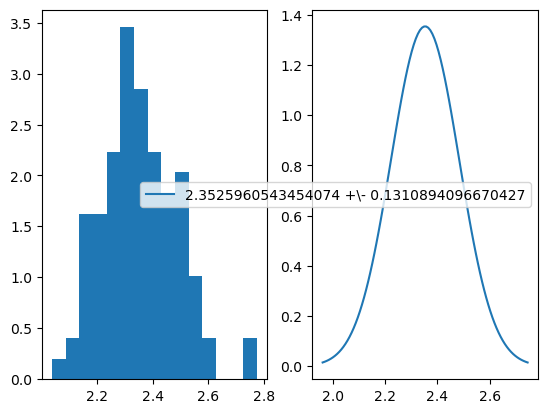

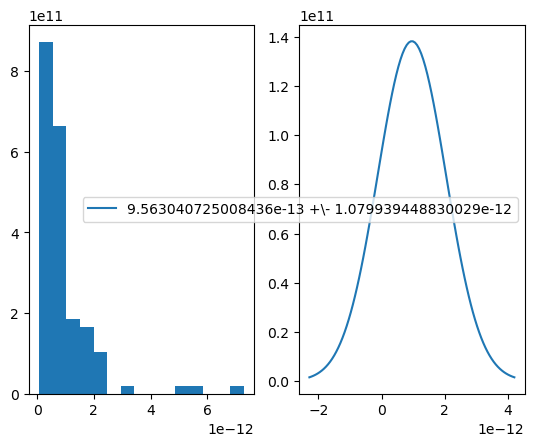

In [151]:
temp = np.array([exp])
par = np.array(['index','amplitude'])
Res_mean = []
Res_sigma = []

for j in temp:              #for every exposure time
    ext = int(j)
    result = table.read(f"./{Nsim}sims/best-fit/{MainSource}_{ext}hr_results.fits")
    for name in par:        #loop over the parameters to be computed
        mean = np.mean(result[name])
        sigma = np.sqrt(np.var(result[name]))
        Res_mean.append(mean)
        Res_sigma.append(sigma)
            #fig = plt.figure()
            #n, bins, patches = plt.hist(result[name], bins=15, density=True)
        figure, axs = plt.subplots(1, 2)
        n, bins, patches = axs[0].hist(result[name], bins=15, density=True)
        x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
            #plt.figure()
            #plt.plot(x, gaussian(x, np.mean(n), mean, sigma), label=f"{mean} +\- {sigma}")
        axs[1].plot(x, gaussian(x, np.mean(n), mean, sigma), label=f"{mean} +\- {sigma}")
        plt.legend()
        filename = f"./{Nsim}sims/best-fit/{MainSource}_{name}_{ext}hr_hist.png"

print(Res_mean)
print(Res_sigma)

In [152]:
e_bins = 10    #spectral bins
path = BASE_PATH / f"{Nsim}sims/spectra/"

### Creation of paramter arrays with dimensions=number of exposure times
flux = np.zeros((len(temp),e_bins-1,Nsim), float)
sqrt_ts = np.zeros((len(temp),e_bins-1,Nsim), float)
ts = np.zeros((len(temp),e_bins-1,Nsim), float)

for k in np.arange(len(temp)):           # for every exposure time
    j=0
    for filename in path.glob(f"{MainSource}_{ext}hr_spectrum*.fits"): # for every simulation
        for i in np.arange(e_bins-1):                 #for every energy bin
            tab = Table.read(filename, hdu=1)
            tab['ref_dnde'] = tab['ref_dnde'].quantity.to("1 / (TeV s cm2)")
            if str(tab['ref_dnde'][i]) != 'nan':
                flux[k,i,j] = tab['ref_dnde'][i]
                sqrt_ts[k,i,j] = tab['sqrt_ts'][i]
                ts[k,i,j] = tab['ts'][i]
            else:
                flux[k,i,j] = tab['ref_dnde'][i]
                sqrt_ts[k,i,j] = tab['sqrt_ts'][i]
                ts[k,i,j] = tab['ts'][i]
        j += 1 
print('Flux')
print(flux)
print('sqrt_TS')
print(sqrt_ts)
print('TS')
print(ts)

sqrt_ts[np.isnan(sqrt_ts)] = 0                #if we have a NAN, put in 0

Flux
[[[8.19560410e-12 5.77566929e-12 8.33009942e-12 7.95357020e-12
   7.28111202e-12 1.09290669e-11 7.46198961e-12 4.64298318e-12
   7.43638801e-12 6.65383590e-12 5.49714856e-12 6.07503344e-12
   2.66697398e-12 6.23833356e-12 1.02497998e-11 6.05444466e-12
   4.77012466e-12 5.34979268e-12 6.67178962e-12 5.59610819e-12
   6.50489776e-12 6.97757693e-12 8.80568562e-12 6.16577998e-12
   7.77609943e-12 3.82846791e-12 6.81660844e-12 7.83719584e-12
   8.77248939e-12 7.03671720e-12 6.37429012e-12 4.30819394e-12
   7.51638682e-12 6.58324651e-12 6.78465914e-12 5.21104432e-12
   5.02680524e-12 8.70956818e-12 4.87941431e-12 5.93458710e-12
   6.61160459e-12 5.03615093e-12 5.94339889e-12 4.56481777e-12
   4.77063267e-12 5.40191250e-12 1.36307516e-11 4.74144056e-12
   4.29806463e-12 8.28620227e-12 5.69678308e-12 5.40535462e-12
   5.76461356e-12 6.46443203e-12 8.00237843e-12 7.47179480e-12
   6.24346182e-12 7.90220379e-12 6.06707475e-12 7.00011348e-12
   3.41120728e-12 5.93288298e-12 8.08590029e-12 5.

In [153]:
import pandas as pd
path = (BASE_PATH / f"{Nsim}sims/best-fit")

for k in np.arange(len(temp)):       #for every exposure time
    e_ref = []
    e_min_ar = []
    e_max_ar = []
    dnde = []
    dnde_ul = []    
    dnde_err = []
    is_ul = []
    for i in np.arange(e_bins-1):    # for every energy bin
        print('The TS mean is:', np.mean(ts[k,i]))
        if np.mean(sqrt_ts[k,i])>=2.5:                 # the condition is always on the average of the TS (usually 9)
            mean = np.mean(flux[k,i])
            sigma = np.sqrt(np.var(flux[k,i]))
            e_ref.append(tab['e_ref'][i])
            e_min_ar.append(tab['e_min'][i])
            e_max_ar.append(tab['e_max'][i])
            dnde.append(mean)
            dnde_ul.append(mean)
            dnde_err.append(sigma)
            is_ul.append(False)

        else:
            e_ref.append(tab['e_ref'][i])
            e_min_ar.append(tab['e_min'][i])
            e_max_ar.append(tab['e_max'][i])
            dnde.append(np.max(stats.norm.interval(0.95, loc=mean, scale=sigma)))
            dnde_ul.append(np.max(stats.norm.interval(0.95, loc=mean, scale=sigma)))
            dnde_err.append(np.max(stats.norm.interval(0.95, loc=mean, scale=sigma)))
            is_ul.append(True)
#when the TS distribution was not significant in a given energy bin, we calculated a 95% confidence
#level upper limit on flux from the distribution of the simulated fluxes.

    a = Table()
    a['e_min'] = e_min_ar * u.TeV
    a['e_max'] = e_max_ar * u.TeV
    a['e_ref'] = e_ref * u.TeV
    a['dnde'] = dnde 
    a['dnde'].unit = 'cm^-2 s^-1 TeV^-1'
    a['dnde_ul'] = dnde_ul 
    a['dnde_ul'].unit = 'cm^-2 s^-1 TeV^-1'
    a['dnde_err'] = dnde_err
    a['dnde_err'].unit = 'cm^-2 s^-1 TeV^-1'
    a['is_ul'] = is_ul
    a.meta["SED_TYPE"]="dnde    "
    
    filename=path / f'{MainSource}_{temp[k]}hr_average_spectrum.fits'
    a.write(filename, overwrite='True')

The TS mean is: 3.793235014360398
The TS mean is: 11.03658736927202
The TS mean is: 12.07353346279473
The TS mean is: 12.330426136336754
The TS mean is: 12.690217069477658
The TS mean is: 6.073070157608308
The TS mean is: 2.635162594364083
The TS mean is: 1.6222222108219284
The TS mean is: 1.4524899191508303


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


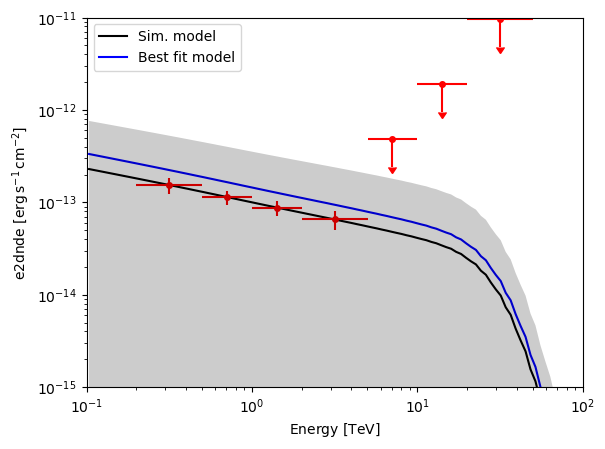

In [154]:
temp = np.array([ext])
path = (BASE_PATH / f"{Nsim}sims/best-fit")
for k in np.arange(len(temp)):
    filename=path / f'{MainSource}_{temp[k]}hr_average_spectrum.fits'
    dati = FluxPoints.read(filename)
    ax = dataset_original[0].spectral_model.plot(            #input model
        energy_bounds=[e_min, e_max] * u.TeV, 
        sed_type="e2dnde",
        label="Sim. model", 
        color='black'
        )
    
    #We need to overlap the average model obtained by all the best-fit models
    dataset_mean = dataset_original.copy()
    dataset_mean[0].spectral_model.parameters[0].value = Res_mean[0]
    dataset_mean[0].spectral_model.parameters[0].error = Res_sigma[0]
    dataset_mean[0].spectral_model.parameters[1].value = Res_mean[1]
    dataset_mean[0].spectral_model.parameters[1].error = Res_sigma[1]
    # dataset_mean[0].spectral_model.lambda_.value = Res_mean[2]
    # dataset_mean[0].spectral_model.lambda_.error = Res_sigma[2]

    px = {"color": "red", "marker":"o"}
    mx = {"color": "blue"}

    flux_points_dataset = FluxPointsDataset(data=dati, models=dataset_mean[0])
    flux_points_dataset.plot_spectrum(ax=ax, kwargs_fp=px, kwargs_model=mx)
    ax.legend()
    ax.set_ylim(1.e-15,1e-11)
filename = path / f'{MainSource}_{temp[k]}hr_average_spectrum.png'
#    save_figure(filename)